# Imports and parameters

In [15]:
from __future__ import annotations
import time
from urllib.parse import urlencode
from typing import Dict, List, Tuple, Iterable, Optional

import requests
import pandas as pd
import networkx as nx
from tqdm.auto import tqdm

In [16]:
BASE = "https://api.openalex.org"
DEFAULT_PER_PAGE = 200  # max per page for /works
POLITE_MAILTO = None    # e.g., "[email protected]" to join the polite pool
RATE_SLEEP_S = 0.12     # ~8–9 req/s to stay under 10 req/s

# Main functions

In [17]:
def _request(url: str, params: Optional[Dict]=None) -> Dict:
    params = dict(params or {})
    if POLITE_MAILTO:
        params.setdefault("mailto", POLITE_MAILTO)
    r = requests.get(url, params=params, timeout=60)
    r.raise_for_status()
    return r.json()

def search_work_id(query: str) -> str:
    """
    Return OpenAlex work id URL (e.g., 'https://openalex.org/W2741809807')
    for a title/keyword query using /works?search=...
    """
    data = _request(f"{BASE}/works", {"search": query, "per_page": 1})
    results = data.get("results", [])
    if not results:
        raise ValueError(f"No work found for search={query!r}")
    return results[0]["id"]

def normalize_work_identifier(seed: str) -> str:
    """
    Accepts:
      - OpenAlex work URL/id, e.g. 'https://openalex.org/W...'
      - DOI string, e.g. '10.1038/nature12373'
      - Title/keywords (falls back to search)
    Returns the canonical OpenAlex work URL (https://openalex.org/W...).
    """
    s = seed.strip()
    if s.startswith("http") and "openalex.org" in s:
        # Already an OpenAlex URL
        return s
    if s.lower().startswith("10."):
        # DOI → OpenAlex works/https://doi.org/...
        # (OpenAlex accepts either doi:10.x or full https://doi.org/10.x in the ID path;
        # using the https://doi.org/ form here.)
        return f"https://openalex.org/works/https://doi.org/{s}"
    # Otherwise, treat as search query (title/keywords)
    return search_work_id(s)

def get_work(work_url: str) -> Dict:
    """
    Fetch the work object given an OpenAlex work URL (or id path).
    Accepts both app and API forms; normalizes to API.
    """
    if "api.openalex.org" in work_url:
        url = work_url
    else:
        seg = work_url.split("openalex.org/")[-1]
        url = f"{BASE}/{seg}"
    return _request(url)

def list_forward_citers(work_url: str,
                        since: Optional[int]=None,
                        until: Optional[int]=None,
                        per_page: int=DEFAULT_PER_PAGE) -> List[Dict]:
    """
    Return all works that cite the given work (forward citations).
    Uses the work's 'cited_by_api_url' with cursor pagination.
    Optional year filters (inclusive).
    """
    w = get_work(work_url)
    cited_by_url = w.get("cited_by_api_url")
    if not cited_by_url:
        return []

    # Build filter
    flt = []
    if since is not None:
        flt.append(f"publication_year:>{since-1}")
    if until is not None:
        flt.append(f"publication_year:<{until+1}")
    filter_str = ",".join(flt) if flt else None

    params = {"per_page": per_page, "cursor": "*"}
    if filter_str:
        params["filter"] = filter_str

    results = []
    while True:
        data = _request(cited_by_url, params)
        results.extend(data.get("results", []))
        cursor = data.get("meta", {}).get("next_cursor")
        if not cursor:
            break
        params["cursor"] = cursor
        time.sleep(RATE_SLEEP_S)
    return results


In [18]:
def forward_citation_graph(seed: str,
                           depth: int = 1,
                           since: Optional[int] = None,
                           until: Optional[int] = None,
                           max_nodes: int = 1000,
                           progress: bool = True) -> nx.DiGraph:
    """
    Build a DiGraph where an edge A -> B means "B cites A" (forward citation).
    Traverses up to `depth` levels from the seed.

    Parameters:
      seed: DOI, OpenAlex work URL, or a title search string
      depth: recursion depth (1 = only citers of the seed)
      since/until: optional inclusive year bounds for discovered citers
      max_nodes: safety cap to prevent runaway crawls

    Returns:
      networkx.DiGraph with node attributes: title, year, doi, venue, cited_by_count.
    """
    seed_url = normalize_work_identifier(seed)
    G = nx.DiGraph()
    seen: set[str] = set()
    queue: List[Tuple[str, int]] = [(seed_url, depth)]

    pbar = tqdm(disable=not progress, total=None, desc="Traversing")

    while queue and G.number_of_nodes() < max_nodes:
        current, dleft = queue.pop(0)
        if current in seen:
            continue
        seen.add(current)

        try:
            w = get_work(current)
        except Exception as e:
            print(f"[WARN] Failed to get {current}: {e}")
            continue

        node_id = w["id"]  # canonical OpenAlex URL
        G.add_node(
            node_id,
            title=w.get("title"),
            year=w.get("publication_year"),
            doi=w.get("doi") or "",
            venue=(w.get("primary_location", {}) \
                     .get("source", {}) or {}).get("display_name", ""),
            cited_by_count=w.get("cited_by_count", 0),
        )

        if dleft <= 0:
            pbar.update(1)
            continue

        try:
            citers = list_forward_citers(node_id, since=since, until=until)
        except Exception as e:
            print(f"[WARN] Failed to list citers for {node_id}: {e}")
            pbar.update(1)
            continue

        # Add citers and edges
        for cw in citers:
            cw_id = cw["id"]
            if cw_id not in G:
                G.add_node(
                    cw_id,
                    title=cw.get("title"),
                    year=cw.get("publication_year"),
                    doi=cw.get("doi") or "",
                    venue=(cw.get("primary_location", {}) \
                              .get("source", {}) or {}).get("display_name", ""),
                    cited_by_count=cw.get("cited_by_count", 0),
                )
            # Edge: seed/current -> citer (forward)
            if not G.has_edge(node_id, cw_id):
                G.add_edge(node_id, cw_id)

        # Enqueue next layer
        for cw in citers:
            if cw["id"] not in seen and G.number_of_nodes() < max_nodes:
                queue.append((cw["id"], dleft - 1))

        pbar.update(1)

    pbar.close()
    return G


# Helper functions


In [19]:
def graph_to_dataframes(G: nx.DiGraph) -> Tuple[pd.DataFrame, pd.DataFrame]:
    nodes = []
    for nid, data in G.nodes(data=True):
        nodes.append({
            "id": nid,
            "title": data.get("title"),
            "year": data.get("year"),
            "doi": data.get("doi"),
            "venue": data.get("venue"),
            "cited_by_count": data.get("cited_by_count"),
        })
    edges = [{"source": u, "target": v} for u, v in G.edges()]
    return pd.DataFrame(nodes), pd.DataFrame(edges)

def save_outputs(G: nx.DiGraph, prefix: str = "openalex_forward"):
    nodes_df, edges_df = graph_to_dataframes(G)
    nodes_df.to_csv(f"{prefix}_nodes.csv", index=False)
    edges_df.to_csv(f"{prefix}_edges.csv", index=False)
    nx.write_gexf(G, f"{prefix}.gexf")
    print(f"Saved: {prefix}_nodes.csv, {prefix}_edges.csv, {prefix}.gexf")


# Run it

In [ ]:
# EXAMPLES for `seed`:
# - DOI: "10.1038/nature12373"
# - OpenAlex: "https://openalex.org/W2741809807"
# - Title/keywords: "Attention is all you need"

POLITE_MAILTO = "e.bergsma@pl.hanze.nl"   # strongly recommended
seed = "10.1109/ACCESS.2021.3078549"         # ← change me
depth = 2
since = 2018
until = None
max_nodes = 400

In [ ]:
G = forward_citation_graph(
    seed=seed,
    depth=depth,
    since=since,
    until=until,
    max_nodes=max_nodes,
    progress=True
)

nodes_df, edges_df = graph_to_dataframes(G)
display(nodes_df.head(10))
display(edges_df.head(10))
print("Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())


Traversing: 0it [00:00, ?it/s]

KeyboardInterrupt: 

In [24]:
G=test

nodes_df, edges_df = graph_to_dataframes(G)
display(nodes_df.head(10))
display(edges_df.head(10))
print("Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())

,id,title,year,doi,venue,cited_by_count
0,https://openalex.org/W3163755028,"Internet of Things 2.0: Concepts, Applications...",2021,https://doi.org/10.1109/access.2021.3078549,IEEE Access,102
1,https://openalex.org/W4210879646,A Review on Antenna Technologies for Ambient R...,2022,https://doi.org/10.1109/access.2022.3149276,IEEE Access,148
2,https://openalex.org/W4366977512,"Ethical hacking for IoT: Security issues, chal...",2023,https://doi.org/10.1016/j.iotcps.2023.04.002,Internet of Things and Cyber-Physical Systems,85
3,https://openalex.org/W4394804988,Secure Multi-Party Computation for Machine Lea...,2024,https://doi.org/10.1109/access.2024.3388992,IEEE Access,33
4,https://openalex.org/W4407985823,IoT‐5G and B5G/6G resource allocation and netw...,2025,https://doi.org/10.1049/ntw2.70002,IET Networks,7
5,https://openalex.org/W3211742690,Machine Learning in Beyond 5G/6G Networks—Stat...,2021,https://doi.org/10.3390/electronics10222786,Electronics,91
6,https://openalex.org/W4312349588,"Internet of Things: Device Capabilities, Archi...",2022,https://doi.org/10.1109/jiot.2022.3228795,IEEE Internet of Things Journal,80
7,https://openalex.org/W4388966623,Toward Enhanced Attack Detection and Explanati...,2023,https://doi.org/10.1109/access.2023.3336678,IEEE Access,30
8,https://openalex.org/W4322576550,<i>Trust–SIoT</i>: Toward Trustworthy Object C...,2023,https://doi.org/10.1109/tnsm.2023.3247831,IEEE Transactions on Network and Service Manag...,28
9,https://openalex.org/W4320473171,Tracking the Research on Ten Emerging Digital ...,2023,https://doi.org/10.1061/jcemd4.coeng-12290,Journal of Construction Engineering and Manage...,27


,source,target
0,https://openalex.org/W3163755028,https://openalex.org/W4210879646
1,https://openalex.org/W3163755028,https://openalex.org/W4366977512
2,https://openalex.org/W3163755028,https://openalex.org/W4394804988
3,https://openalex.org/W3163755028,https://openalex.org/W4407985823
4,https://openalex.org/W3163755028,https://openalex.org/W3211742690
5,https://openalex.org/W3163755028,https://openalex.org/W4312349588
6,https://openalex.org/W3163755028,https://openalex.org/W4388966623
7,https://openalex.org/W3163755028,https://openalex.org/W4322576550
8,https://openalex.org/W3163755028,https://openalex.org/W4320473171
9,https://openalex.org/W3163755028,https://openalex.org/W4389080276


Nodes: 103 Edges: 102


# Visualize

Saved: openalex_forward_nodes.csv, openalex_forward_edges.csv, openalex_forward.gexf


Traversing: 0it [07:02, ?it/s]


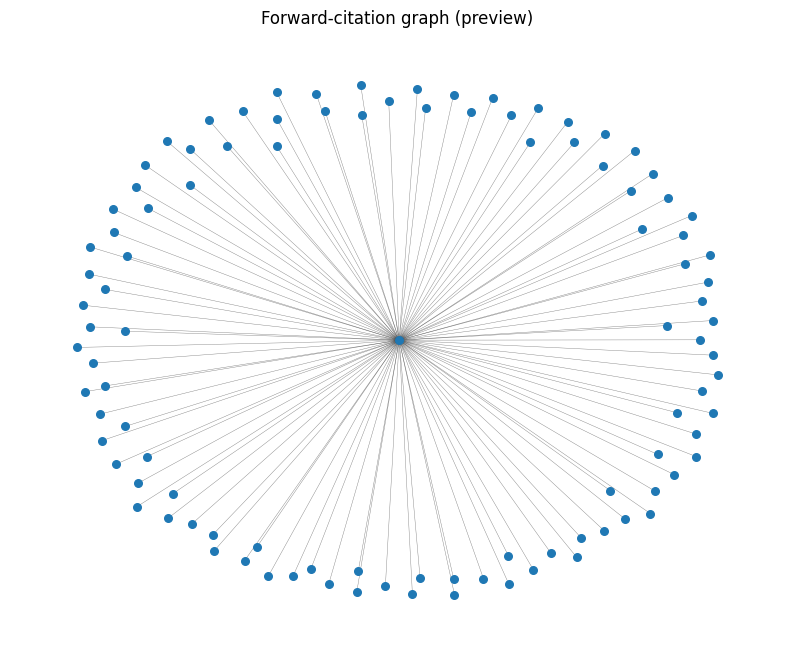

In [25]:
save_outputs(G, prefix="openalex_forward")

# Quick sanity plot for smaller graphs (< 500 nodes recommended)
# This is just a rough preview; for real analysis use Gephi/VOSviewer/etc.
if G.number_of_nodes() <= 500:
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, k=0.3, seed=42)
    nx.draw_networkx_nodes(G, pos, node_size=30)
    nx.draw_networkx_edges(G, pos, width=0.3, alpha=0.5, arrows=False)
    plt.title("Forward-citation graph (preview)")
    plt.axis("off")
    plt.show()
